In [1]:
import pickle
import os
import re

from typing import List

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import nltk
nltk.download('stopwords')

from autocorrect import Speller
from nltk import word_tokenize
from nltk import FreqDist
import pymorphy2

from spylls.hunspell import Dictionary

from yellowbrick.cluster import KElbowVisualizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup

from visualize import interactive_graph

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sanya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Настройки

In [2]:
# Директории
HTML_DIR = 'resumes'                     # Директория с html-файлами
ABBREVIATIONS_FILE = 'abbreviations.bin' # Файл с необходимыми сокращениями слов
MISPRINT_FILE = 'misprints.bin'          # Файл с возможными опечатками слов

# Кластеризация
N_CLUSTERS = 'auto'     # Количество кластеров. Если указано 'auto', то количество подберется автоматически
SEARCH_RANGE = (30, 35) # Диапазон, в котором ищется оптимальное количество кластеров
MAX_ITER = 300          # Максимальное количество итераций для одного запуска K-средних
ALGORITHM = 'lloyd'     # Используемый алгоритм K-средних ("lloyd", "elkan")
N_INIT = 'auto'         # Количество запусков k-средних с разными начальными значениями центроида

# Парсинг html-файлов

In [3]:
def parse_CV(file: str):
    
    soup = BeautifulSoup(open(file, encoding = "utf8"), 'html.parser')
    row = pd.Series()

    row['title'] = soup.find('span', class_ = 'resume-block__title-text').text.strip()
    row['specializations'] = ','.join([x.text for x in soup.find_all('li', class_ = 'resume-block__specialization')])
    row['description'] = '. '.join([x.text for x in soup.find_all('div', {'data-qa': 'resume-block-experience-description'})])

    return row  

In [4]:
df = pd.DataFrame(columns = ['title', 'specializations', 'description'])

for file in tqdm(os.listdir(HTML_DIR)):
    df.loc[len(df.index)] = parse_CV(os.path.join(HTML_DIR, file))

100%|██████████| 1001/1001 [00:20<00:00, 49.53it/s]


In [5]:
df.head(20)

,title,specializations,description
0,Агроном,Агроном,"Проверка качества сбора огурца,\nРабота с перв..."
1,Агроном,Агроном,"Консультация,менеджмент, продажа минеральных у..."
2,Инженер-механик,"Сервисный инженер, инженер-механик,Механик",организация рабочего дня.определение неполадок...
3,"Машинист экскаватора А,B,C,D,F, 8 ( восьмого р...",Машинист,"Погрузка руды в автомашины Белаз, Volvo сочле..."
4,Зоотехник по кормлению КРС,Зоотехник,Контроль поедаемости кормов животными.\nКоррек...
5,Главный зоотехник,Зоотехник,"Работа с персоналом, уход за животными, реклама"
6,Инженер-механик,"Сервисный инженер, инженер-механик,Механик",Полный монтаж и пуско наладка оборудования ут...
7,"Агроном, озеленитель, руководитель подразделения",Агроном,Организация производства питомника. Организац...
8,Ветеринарный врач,Ветеринарный врач,"Выявление мастита, гинекология,лечение молодняка"
9,"Ветеринарный фельдшер, начальник комплекса.",Ветеринарный врач,"Ведение документов, программа 1С и АВСС,органи..."


# Препроцессинг

In [6]:
# Загрузка файла с сокращениями
with open(ABBREVIATIONS_FILE, 'rb') as file:
    abbreviations = pickle.load(file)

abbreviations = {k: v for k, v in sorted(abbreviations.items(), key = lambda item: len(item[0]), reverse = True)}

In [7]:
def save_misprints(texts: List[str], save_path: str):

    speller = Speller(lang = 'ru')

    # Словарь с исправленными словами
    corrects = {}

    for text in tqdm(texts):
        
        for word in text.split():
            corrected = speller(word)
            if word != corrected:
                corrects[word] = corrected


    with open(save_path, 'wb') as file:
        pickle.dump(corrects, file)

In [8]:
# Создать словарь с опечатками, если его не существует 
if not os.path.exists(MISPRINT_FILE):
    save_misprints(df['description'].values, MISPRINT_FILE)

# Загрузка файла с опечатками
with open(MISPRINT_FILE, 'rb') as file:
    misprints = pickle.load(file)

In [9]:
def prepocess(text: str):

    # Исправление опечаток
    for key, value in misprints.items():
        try:
            text = re.sub(fr'\b{key}\b', value + ' ', text)
        except Exception:
            continue

    # Удаление пробелов после знаков пунктуации
    text = re.sub(r'(?<=[.])\s', '', text)

    # Раскрытие сокращений
    for key, value in abbreviations.items():
        text = re.sub(fr'\b{key}\b', value + ' ', text)
    
    # Удаление знаков пунктуации
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Перевод текста в нижний регистр
    text = text.lower()
    
    # Токенизация
    text = nltk.tokenize.word_tokenize(text, language = 'russian')
    
    # Лемматизация
    morph = pymorphy2.MorphAnalyzer()
    text = [morph.parse(w)[0].normal_form for w in text]

    return ' '.join(text)

In [10]:
df['description'] = df['description'].progress_apply(prepocess)
df.head(20)

100%|██████████| 1001/1001 [02:22<00:00,  7.02it/s]


,title,specializations,description
0,Агроном,Агроном,проверка качество сбор огурец работа сельский ...
1,Агроном,Агроном,консультация менеджмент продажа минеральный уд...
2,Инженер-механик,"Сервисный инженер, инженер-механик,Механик",организация рабочий день определение неполадка...
3,"Машинист экскаватора А,B,C,D,F, 8 ( восьмого р...",Машинист,погрузка руда в автомашина белаз volvo сочлени...
4,Зоотехник по кормлению КРС,Зоотехник,контроль поедаемость корм животное корректиров...
5,Главный зоотехник,Зоотехник,работа сельский персонал уход за животное реклама
6,Инженер-механик,"Сервисный инженер, инженер-механик,Механик",полный монтаж и пуско наладка оборудование ути...
7,"Агроном, озеленитель, руководитель подразделения",Агроном,организация производство питомник организация ...
8,Ветеринарный врач,Ветеринарный врач,выявление маститый гинекология лечение молодняк
9,"Ветеринарный фельдшер, начальник комплекса.",Ветеринарный врач,ведение документ программа 1с и вс организация...


# Tf-Idf векторизация

In [11]:
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(df['description'].values)

# Кластеризация

In [12]:
def find_n_clasters(vectors, visualize = False): 
    
    model = KMeans(n_clusters = N_CLUSTERS, 
                   max_iter = MAX_ITER, 
                   algorithm = ALGORITHM, 
                   n_init = N_INIT)
    
    visualizer = KElbowVisualizer(model, k = SEARCH_RANGE, timings = True, metric = "distortion")
    visualizer.fit(vectors.toarray())   

    if visualize:  
        visualizer.show()        
        
    return visualizer.elbow_value_

Подбирается количество кластеров...
Количество кластеров = 31


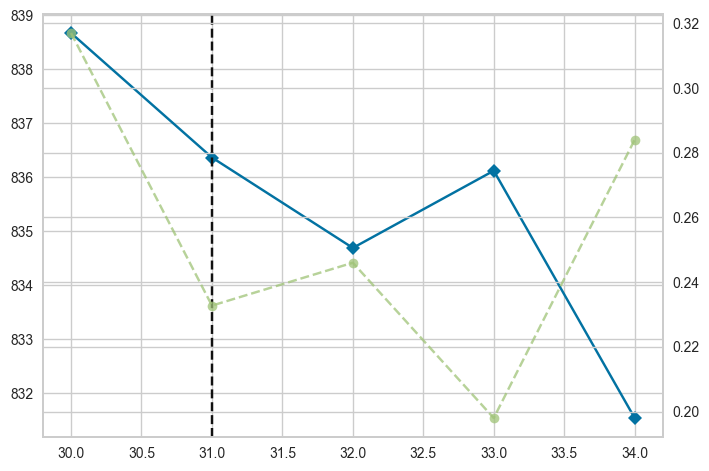

In [13]:
if N_CLUSTERS == 'auto':
    print('Подбирается количество кластеров...')
    N_CLUSTERS = find_n_clasters(tfidf)

print(f'Количество кластеров = {N_CLUSTERS}')

In [14]:
model_tf = KMeans(n_clusters = N_CLUSTERS, 
                  max_iter = MAX_ITER, 
                  algorithm = ALGORITHM, 
                  n_init = N_INIT)

model_tf = model_tf.fit(tfidf)

In [15]:
df['predict'] = model_tf.predict(tfidf)
df.head(20)

,title,specializations,description,predict
0,Агроном,Агроном,проверка качество сбор огурец работа сельский ...,12
1,Агроном,Агроном,консультация менеджмент продажа минеральный уд...,2
2,Инженер-механик,"Сервисный инженер, инженер-механик,Механик",организация рабочий день определение неполадка...,29
3,"Машинист экскаватора А,B,C,D,F, 8 ( восьмого р...",Машинист,погрузка руда в автомашина белаз volvo сочлени...,5
4,Зоотехник по кормлению КРС,Зоотехник,контроль поедаемость корм животное корректиров...,17
5,Главный зоотехник,Зоотехник,работа сельский персонал уход за животное реклама,1
6,Инженер-механик,"Сервисный инженер, инженер-механик,Механик",полный монтаж и пуско наладка оборудование ути...,25
7,"Агроном, озеленитель, руководитель подразделения",Агроном,организация производство питомник организация ...,27
8,Ветеринарный врач,Ветеринарный врач,выявление маститый гинекология лечение молодняк,1
9,"Ветеринарный фельдшер, начальник комплекса.",Ветеринарный врач,ведение документ программа 1с и вс организация...,24


# Нахождение названия кластеров

In [16]:
morph = pymorphy2.MorphAnalyzer()
dict_of_clustering = {}
for i in df['predict'].unique():
    elements = df[df['predict'] == i]['specializations'].values
    elements = re.sub(r'[^\w\s]', ' ', (' '.join(elements)))
    elements = word_tokenize(elements, language = 'russian')
    fdist = FreqDist(elements)

    cluster_name = fdist.most_common(1)[0][0]

    if morph.parse(cluster_name)[0].tag.POS == 'ADJF':
        cluster_name = ' '.join([fdist.most_common(2)[0][0], fdist.most_common(2)[1][0]])

    cluster_name = cluster_name.lower()
    cluster_name = cluster_name.capitalize()
    dict_of_clustering[cluster_name] = df[df['predict'] == i]['specializations'].values

    df['predict'] = df['predict'].replace([i], cluster_name)
df.head(20)

,title,specializations,description,predict
0,Агроном,Агроном,проверка качество сбор огурец работа сельский ...,Инженер
1,Агроном,Агроном,консультация менеджмент продажа минеральный уд...,Инженер
2,Инженер-механик,"Сервисный инженер, инженер-механик,Механик",организация рабочий день определение неполадка...,Инженер
3,"Машинист экскаватора А,B,C,D,F, 8 ( восьмого р...",Машинист,погрузка руда в автомашина белаз volvo сочлени...,Инженер
4,Зоотехник по кормлению КРС,Зоотехник,контроль поедаемость корм животное корректиров...,Зоотехник
5,Главный зоотехник,Зоотехник,работа сельский персонал уход за животное реклама,Ветеринарный врач
6,Инженер-механик,"Сервисный инженер, инженер-механик,Механик",полный монтаж и пуско наладка оборудование ути...,Инженер
7,"Агроном, озеленитель, руководитель подразделения",Агроном,организация производство питомник организация ...,Агроном
8,Ветеринарный врач,Ветеринарный врач,выявление маститый гинекология лечение молодняк,Ветеринарный врач
9,"Ветеринарный фельдшер, начальник комплекса.",Ветеринарный врач,ведение документ программа 1с и вс организация...,Зоотехник


# Визуализация полученных кластеров

In [17]:
dict_of_clustering.keys()

dict_keys(['Инженер', 'Зоотехник', 'Ветеринарный врач', 'Агроном', 'Машинист', 'Технолог'])

In [19]:
interactive_graph(df, clusters = 'predict', elements = 'title')